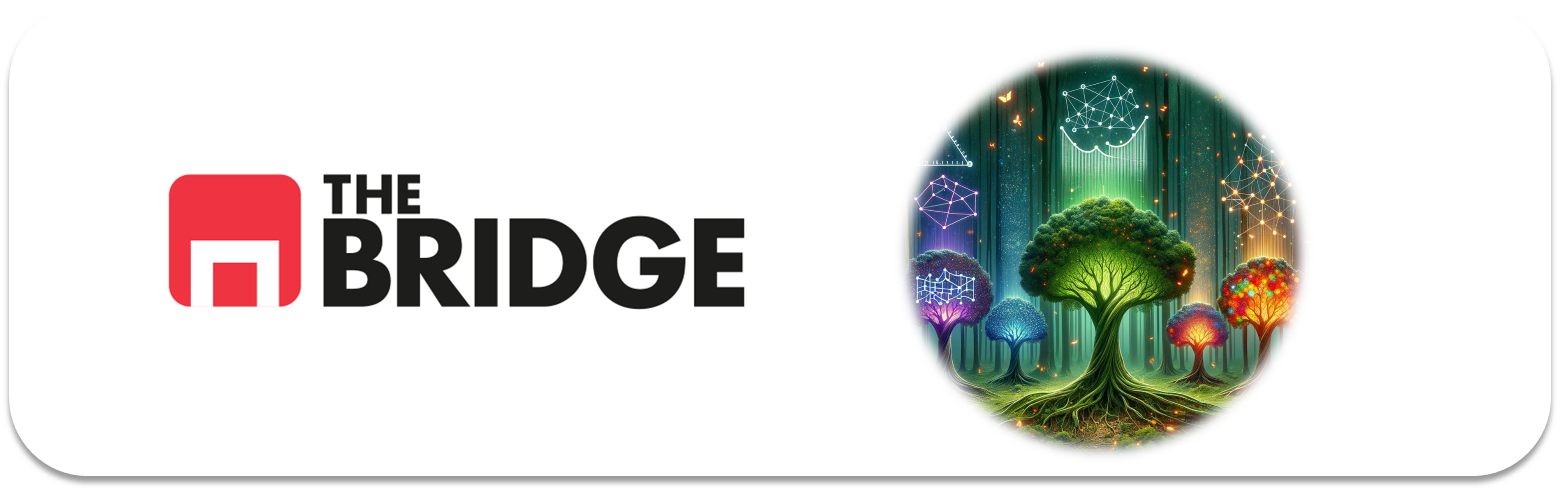

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import bootcampviztools as viz

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

# 1. Carga de datos y clasificación de variables

Comenzamos cargando el dataset y clasificamos las variables

In [3]:
df = pd.read_csv("./data/bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


No hay nulos. Realizamos la clasificación de variables

In [6]:
#Creamos una función para clasificar las variables
def tipifica_variables(df, umbral_categoria, umbral_continua):

    #Creamos una lista con el tipo de cada variable
    lista_tipos = []
        
    #Creamos una lista con la tipificación sugerida para cada variable
    lista_tipificacion = []

    #Creamos dos listas para guardar la cardinalidad de cada variable
    lista_cardinalidad = []
    lista_cardinalidad_porcentaje = []

    #Sugerimos la tipificación de la variable y la guardamos en la lista
    for columna in df.columns:
            
        #Guardamos en la lista el tipo de cada variable
        lista_tipos.append(df[columna].dtypes)
            
        #Calculamos la cardinalidad y la guardamos en las listas
        cardinalidad = df[columna].nunique()
        lista_cardinalidad.append(cardinalidad)
        
        cardinalidad_porcentaje = round(cardinalidad/len(df)*100,2)
        lista_cardinalidad_porcentaje.append(cardinalidad_porcentaje)

        #Clasificamos segun el valor de la cardinalidad
        if cardinalidad == 2:
            lista_tipificacion.append("Binaria")
                
        elif cardinalidad >= umbral_categoria:
                
            if cardinalidad >= umbral_continua:
                lista_tipificacion.append("Numérica continua")
                    
            else: 
                lista_tipificacion.append("Numérica discreta")

        else:
            lista_tipificacion.append("Categórica")

        
    #Creamos el DataFrame con tantas filas como columnas tenga el DataFrame
    df_tipifica = pd.DataFrame({"nombre_variable": df.columns.tolist(), "tipo_variable":lista_tipos, "cardinalidad":lista_cardinalidad, "cardinalidad_porcentaje":lista_cardinalidad_porcentaje , "tipo_sugerido":lista_tipificacion})
    
    return df_tipifica

In [7]:
tipifica_variables(df,umbral_categoria=10,umbral_continua=20)

,nombre_variable,tipo_variable,cardinalidad,cardinalidad_porcentaje,tipo_sugerido
0,age,int64,77,0.17,Numérica continua
1,job,object,12,0.03,Numérica discreta
2,marital,object,3,0.01,Categórica
3,education,object,4,0.01,Categórica
4,default,object,2,0.00,Binaria
5,balance,int64,7168,15.85,Numérica continua
6,housing,object,2,0.00,Binaria
7,loan,object,2,0.00,Binaria
8,contact,object,3,0.01,Categórica
9,day,int64,31,0.07,Numérica continua


Clasificamos las variables:
* age: edad del cliente. Tipo: Numérica continua
* job: situación laboral del cliente. Tipo: Categórica
* marital: estado civil del cliente. Tipo: Categórica
* education: nivel de estudios del cliente. Tipo: Categórica
* default: si el cliente tiene crédito impagado. Tipo: Categórica (binaria)
* balance: media anual del balance en el banco (en euros). Tipo: Numérica continua
* housing: si el cliente tiene un préstamo hipotecario. Tipo: Categórica (binaria)
* loan: si el cliente tiene un préstamo personal. Tipo: Categórica (binaria)
* contact: modo de contacto con el cliente. Tipo: Categórica
* day: último dia del mes de contacto con el cliente. Tipo: Numerica discreta
* month: último mes del año de contacto con el cliente. Tipo: Categórica
* duration: duración en segundos del último contacto con el cliente. Tipo: Numérica continua
* campaign: número de contactos mantenidos en esta campaña con el cliente. Tipo: Numerica discreta
* pdays: número de dias transcurridos desde el último contacto en la campaña anterior con el clente (-1 significa que no hubo contacto previo). Tipo: Numerica discreta
* previous: número de contactos mantenidos en campañas anteriores con el cliente. Tipo: Numerica discreta
* poutcome: resultado de la anterior campaña de marketing. Tipo: Categórica
* y: resultado de la campaña. Tipo: Categórica (binaria)

# 2. Elección del *target*, elección del modelo y separación en train y test

La variable *target* será "y". Revisamos su distribución

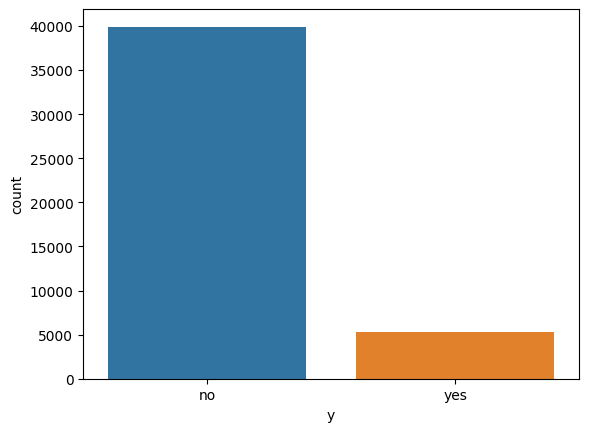

In [8]:
target = "y"
sns.countplot(df, x = target, hue = target);

In [9]:
df[target].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [10]:
df[target].value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

Obtenemos que el dataset está muy desbalanceado hacia el "no" (88%). Escogemos el modelo de árboles de decisión aplicado a un problema de clasificación, aunque al final de la práctica lo compararemos con un modelo de regresión logística

Realizamos la división del DataFrame en train y test con la relación 80/20

In [11]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# 3. Proceso EDA

## 3.1. Variables categóricas

Antes de realizar el análisis bivariante, vamos a agrupar los valores de las variables "day", "month", "campaign", "pdays" y "previous" en categorias

Agrupación de "day" en train y test

In [12]:
#Definimos los intervalos para categorizar
intervalos = [0, 10, 20, 31]

#Definimos las etiquetas para cada intervalo
etiquetas = ['0-10', '11-20', '20-31']

#Creamos una nueva columna en train y test
train_set["day_agrupado"] = pd.cut(train_set["day"], bins=intervalos, labels=etiquetas)
test_set["day_agrupado"] = pd.cut(test_set["day"], bins=intervalos, labels=etiquetas)

#Eliminamos la columna inicial en train y test
train_set.drop(columns=["day"], inplace=True)
test_set.drop(columns=["day"], inplace=True)

#Visualizamos en train
train_set["day_agrupado"].value_counts()

day_agrupado
11-20    14720
0-10     10962
20-31    10486
Name: count, dtype: int64

Agrupación de "month" en train y test

In [13]:
#Definimos la función para clasificar los trimestres
def numero_mes(valor):
    if valor =="jan":
        return "Q1"
    elif valor == "feb":
        return "Q1"
    elif valor == "mar":
        return "Q1"
    elif valor == "apr":
        return "Q2"
    elif valor == "may":
        return "Q2"
    elif valor == "jun":
        return "Q2"
    elif valor == "jul":
        return "Q3"
    elif valor == "aug":
        return "Q3"
    elif valor == "sep":
        return "Q3"
    elif valor == "oct":
        return "Q4"
    elif valor == "nov":
        return "Q4"
    elif valor == "dec":
        return "Q4"

#Clasificamos el trimestre
train_set["month_agrupado"] = train_set["month"].apply(numero_mes)
test_set["month_agrupado"] = test_set["month"].apply(numero_mes)

#Eliminamos la columna inicial en train y test
train_set.drop(columns=["month"], inplace=True)
test_set.drop(columns=["month"], inplace=True)

#Visualizamos en train
train_set["month_agrupado"].value_counts()

month_agrupado
Q2    17625
Q3    10967
Q4     3955
Q1     3621
Name: count, dtype: int64

Agrupación de "campaign" en train y test

In [14]:
#inicializamos con un valor para la nueva columna
train_set["campaign_agrupado"] = ">2"
test_set["campaign_agrupado"] = ">2"

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["campaign"]<=2,"campaign_agrupado"] = "<=2"
test_set.loc[test_set["campaign"]<=2,"campaign_agrupado"] = "<=2"

#Eliminamos la columna inicial
train_set.drop(columns=["campaign"], inplace=True)
test_set.drop(columns=["campaign"], inplace=True)

#Visualizamos en train
train_set["campaign_agrupado"].value_counts()

campaign_agrupado
<=2    24064
>2     12104
Name: count, dtype: int64

Agrupación de "pdays" en train y test

In [15]:
#Inicializamos con un valor para la nueva columna
train_set["pdays_agrupado"] = "previously contacted"
test_set["pdays_agrupado"] = "previously contacted"

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["pdays"] == -1,"pdays_agrupado"] = "not previously contacted"
test_set.loc[test_set["pdays"] == -1,"pdays_agrupado"] = "not previously contacted"

#Eliminamos la columna inicial
train_set.drop(columns=["pdays"], inplace=True)
test_set.drop(columns=["pdays"], inplace=True)

#Visualizamos en train
train_set["pdays_agrupado"].value_counts()

pdays_agrupado
not previously contacted    29556
previously contacted         6612
Name: count, dtype: int64

Agrupación de "previous" en train y test

In [16]:
#inicializamos con un valor para la nueva columna
train_set["previous_agrupado"] = ">2"
test_set["previous_agrupado"] = ">2"

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["previous"]<=2,"previous_agrupado"] = "<=2"
test_set.loc[test_set["previous"]<=2,"previous_agrupado"] = "<=2"

#Eliminamos la columna inicial
train_set.drop(columns=["previous"], inplace=True)
test_set.drop(columns=["previous"], inplace=True)

#Visualizamos en train
train_set["previous_agrupado"].value_counts()

previous_agrupado
<=2    33456
>2      2712
Name: count, dtype: int64

Realizamos el análisis bivariante de las variables categóricas con el *target*

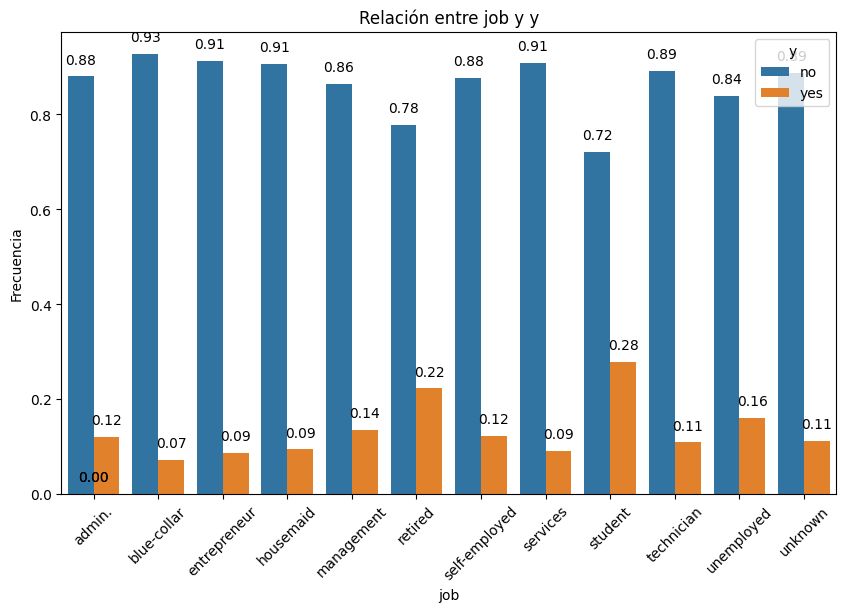

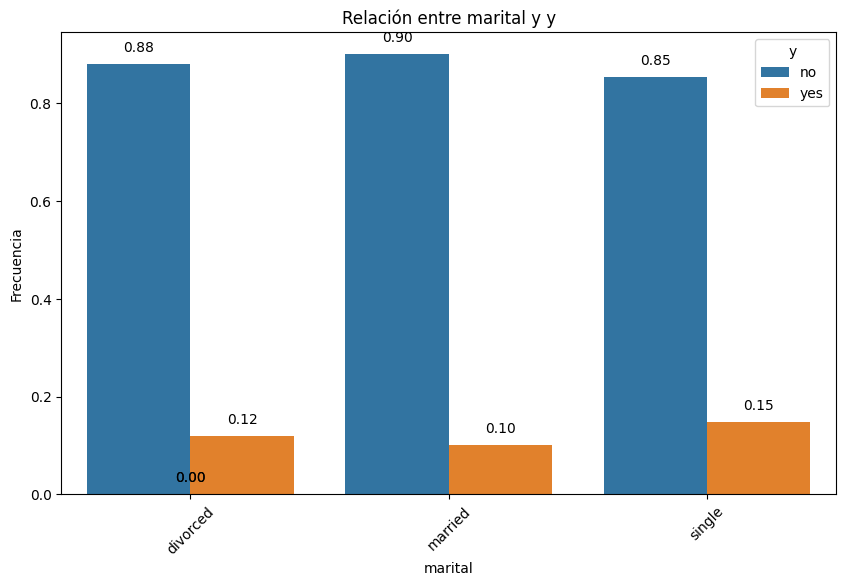

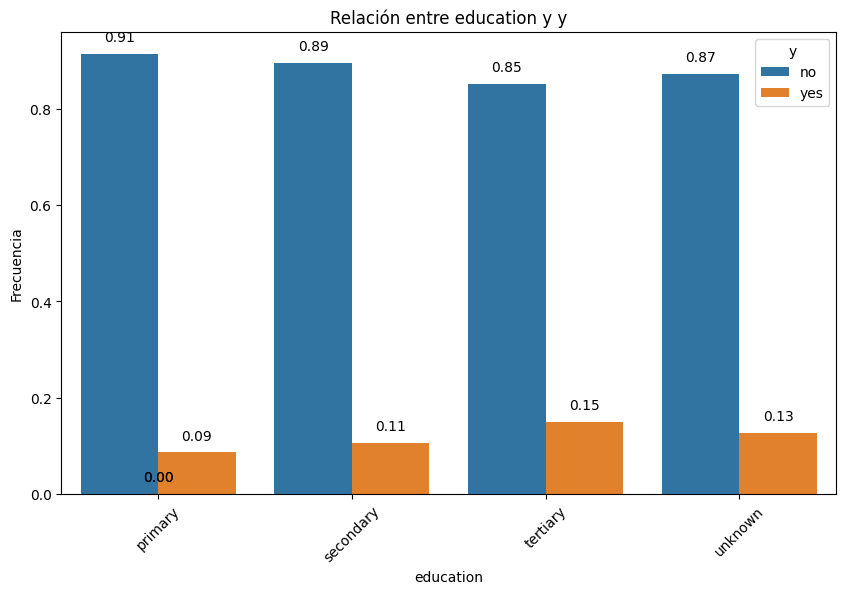

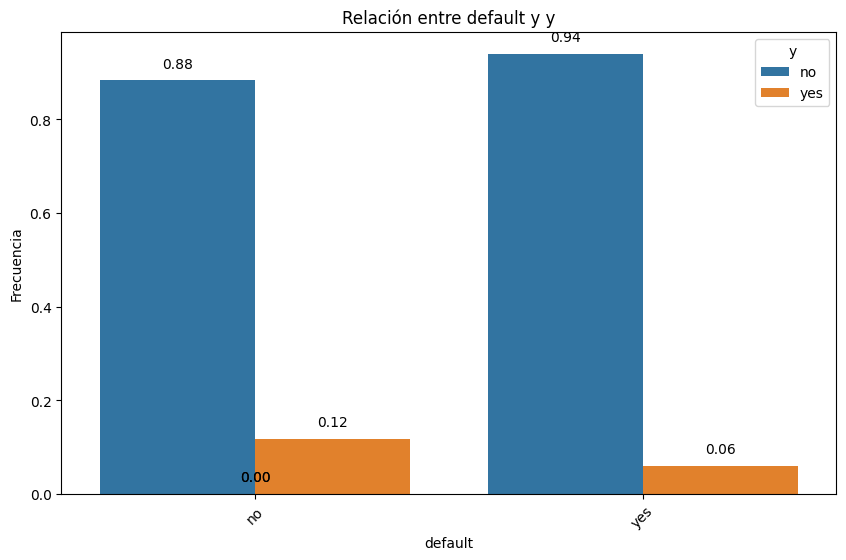

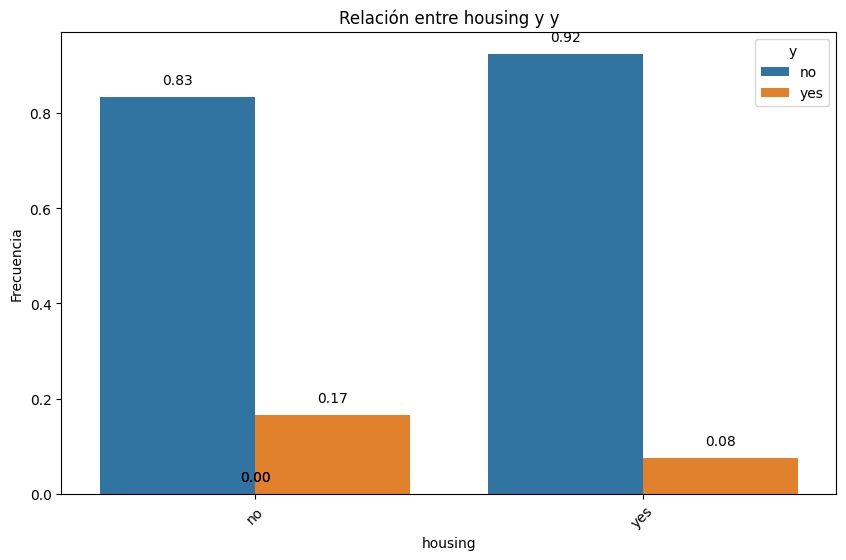

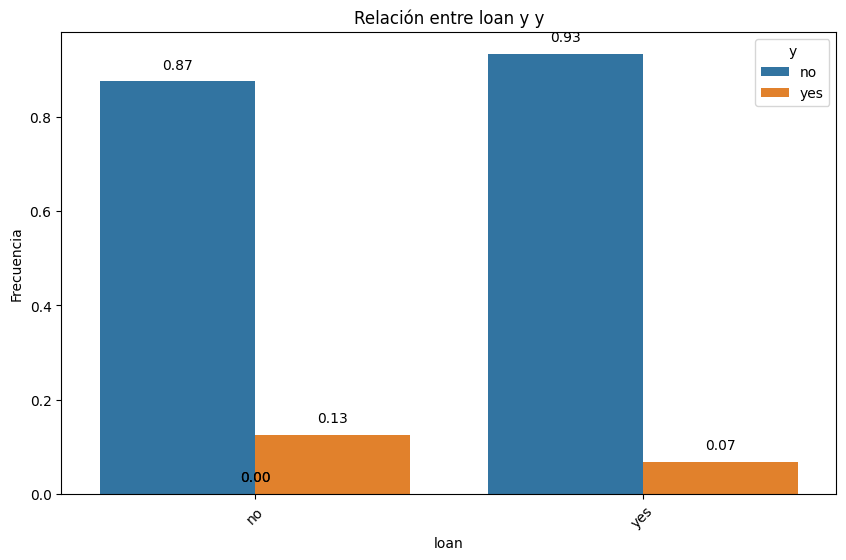

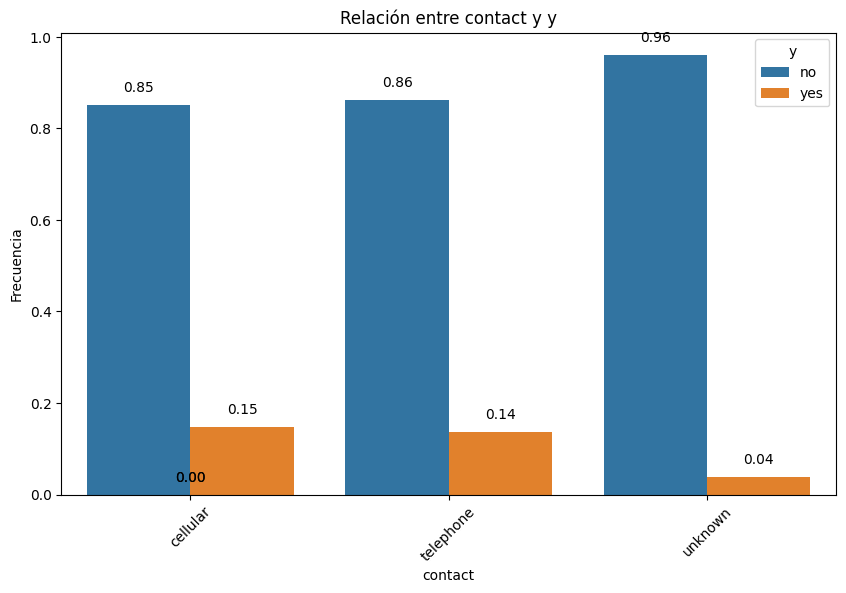

c:\Users\7681\Desktop\Data_Science\ONLINE_DS_THEBRIDGE_ENTREGAS\04_Machine_Learning\Sprint_13\Unidad_01\Practica_Obligatoria\bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


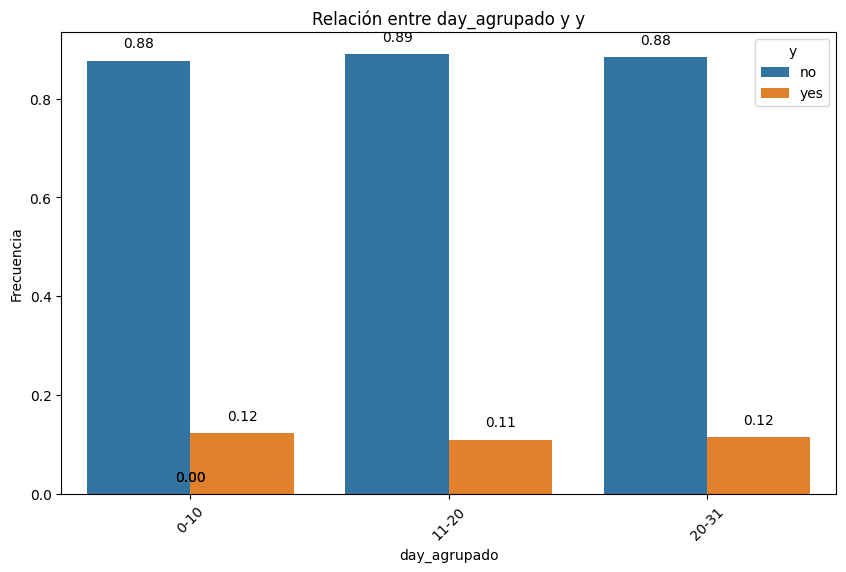

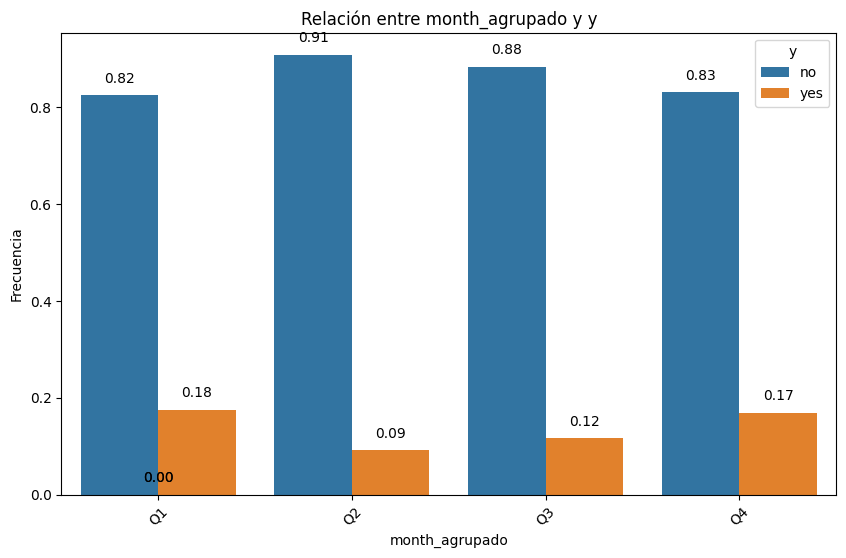

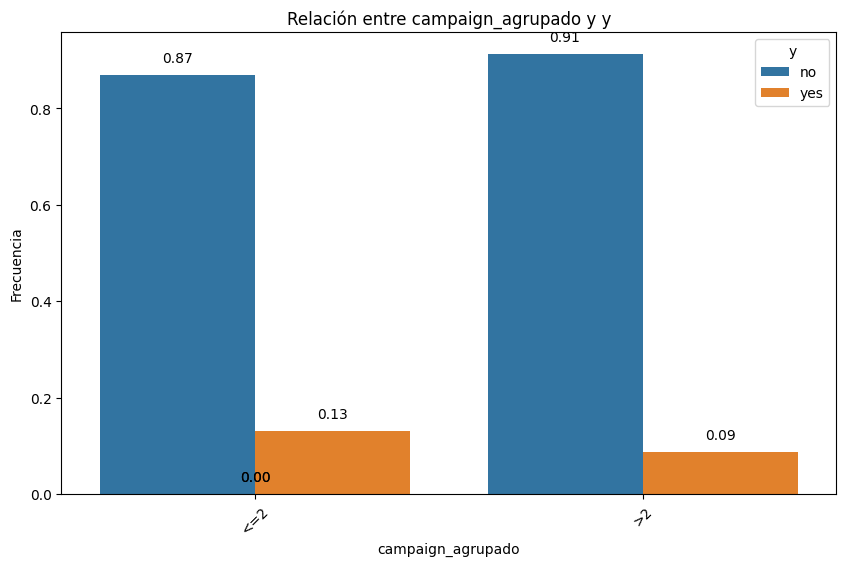

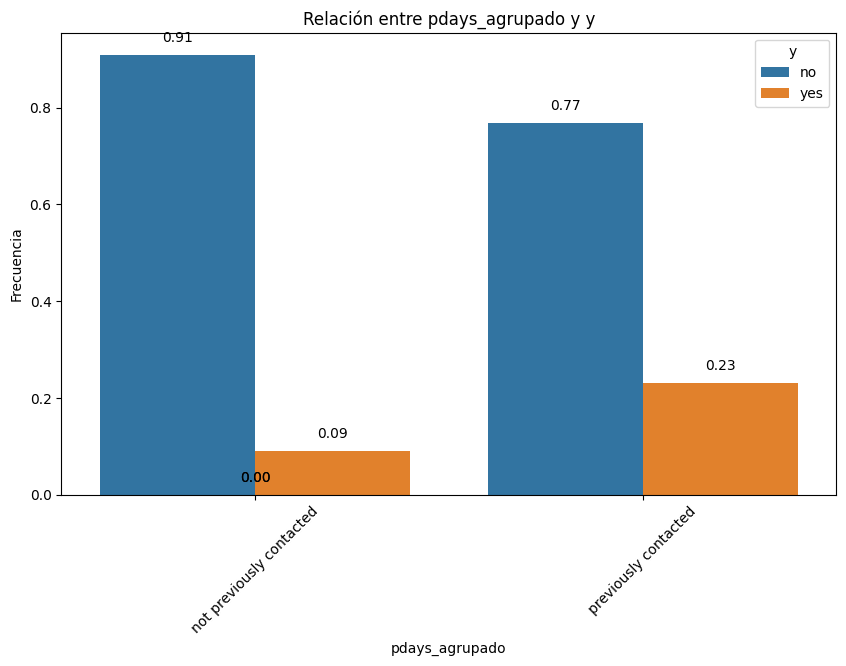

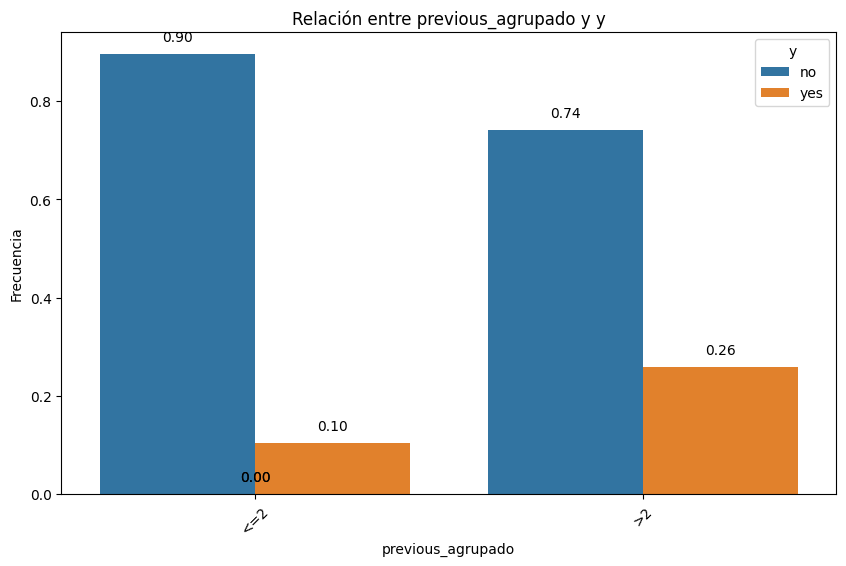

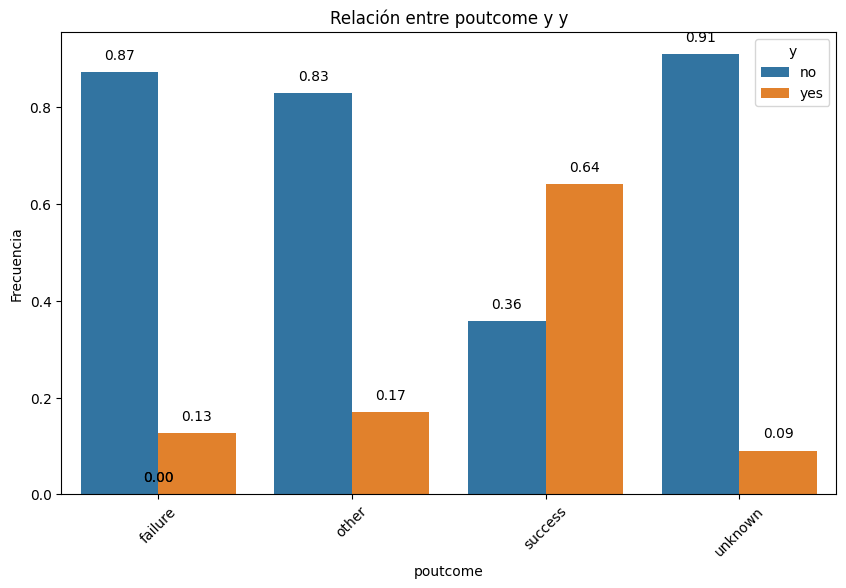

In [17]:
columnas_categoricas = ["job", "marital", "education", "default", "housing", "loan", "contact", "day_agrupado", "month_agrupado", "campaign_agrupado", "pdays_agrupado", "previous_agrupado", "poutcome"]

for columna_categoria in columnas_categoricas:
    viz.plot_categorical_relationship_fin(train_set, cat_col1=columna_categoria, cat_col2=target, relative_freq=True, show_values=True, size_group=12)

Vemos que todas las variables categóricas excepto "marital", "education", "day_agrupado" y "campaign_agrupado" influyen de mayor manera en las distribuciones del *target*. Nos las quedamos como *features* categóricas

In [18]:
features_cat = columnas_categoricas.copy()
categoria_eliminar = ["marital", "education", "day_agrupado", "campaign_agrupado"]

for columna in categoria_eliminar:
    features_cat.remove(columna)

features_cat

['job',
 'default',
 'housing',
 'loan',
 'contact',
 'month_agrupado',
 'pdays_agrupado',
 'previous_agrupado',
 'poutcome']

## 3.2. Variables Numéricas

Realizamos el análisis bivariante de las variables numéricas con el *target*

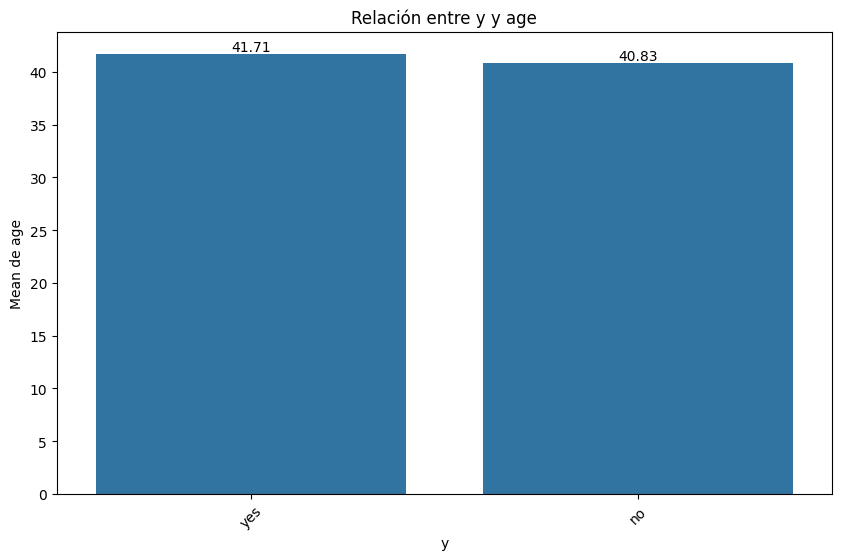

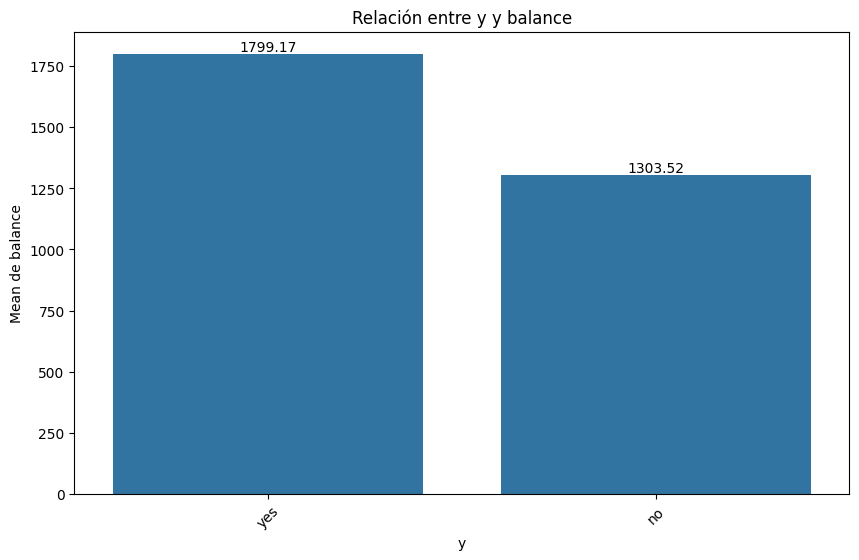

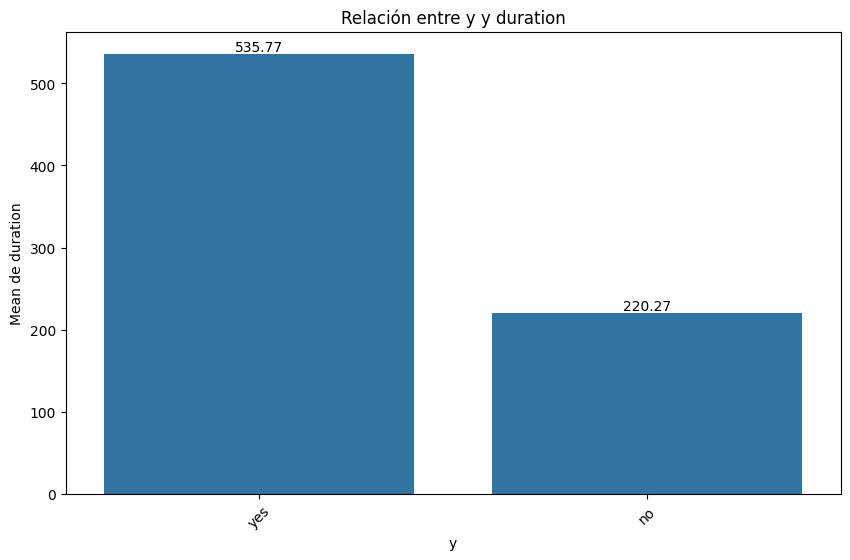

In [19]:
columnas_numericas = ["age", "balance", "duration"]

for columna_numerica in columnas_numericas:
    viz.plot_categorical_numerical_relationship(train_set, categorical_col=target, numerical_col=columna_numerica, show_values=True, measure="mean")

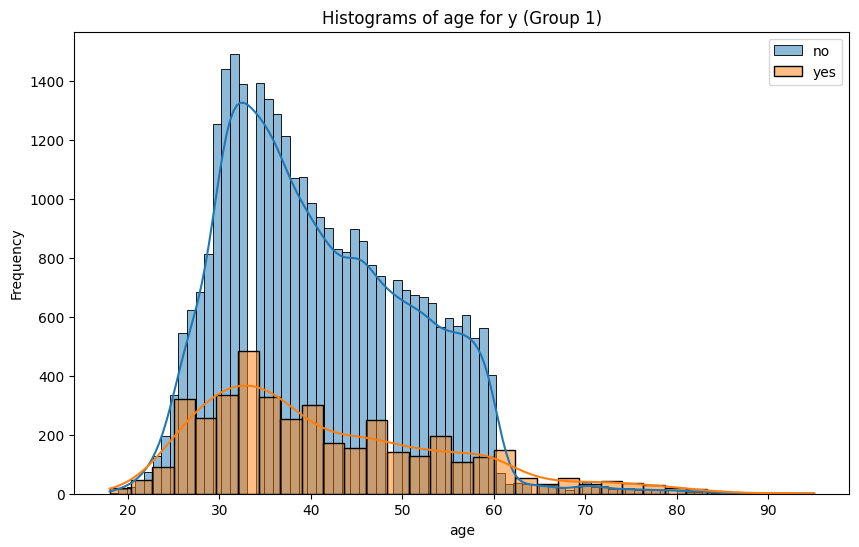

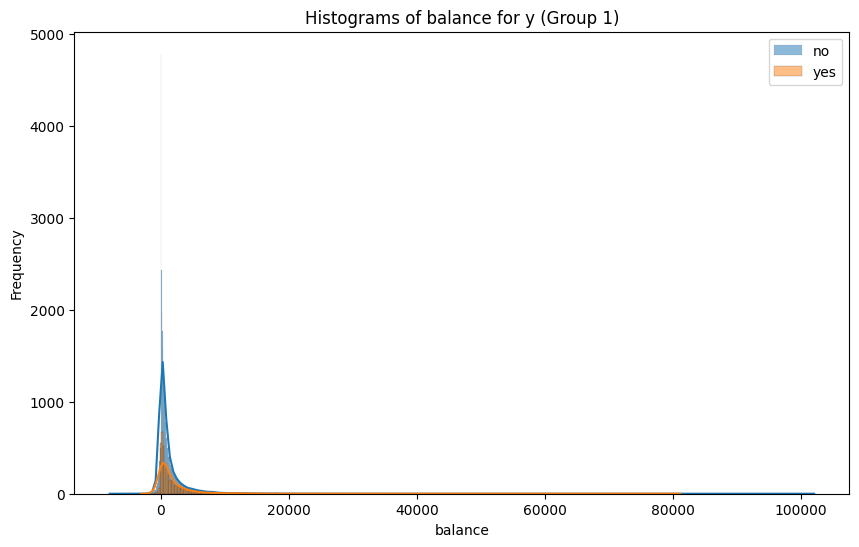

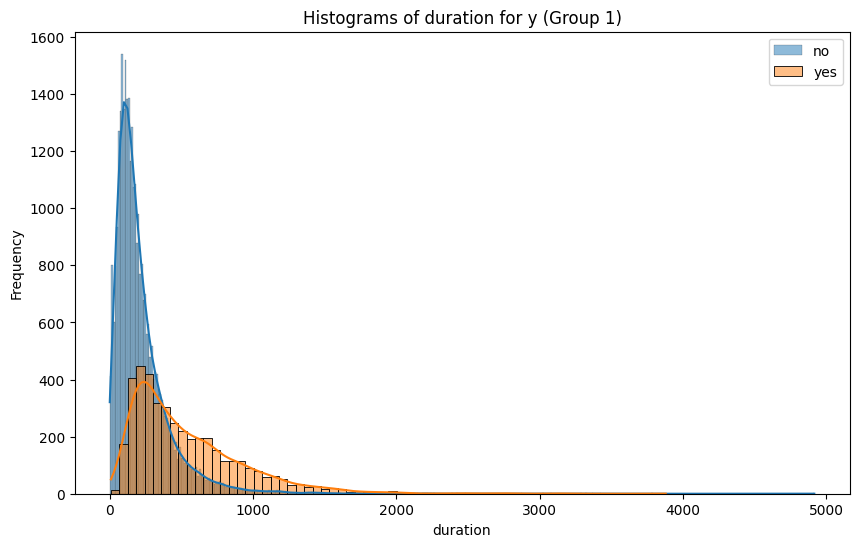

In [20]:
for columna_numerica in columnas_numericas:
    viz.plot_grouped_histograms(train_set, cat_col=target, num_col=columna_numerica, group_size=2)

Las variables que tienen mayor influencia en el *target* son "balance" y "duration". Nos las quedamos como *features* numericas

In [21]:
features_num = ["balance", "duration"]
features_num

['balance', 'duration']

**COMENTARIO**: Si siguieramos un proceso riguroso, las relaciones de las variables con el *target* se deben confirmar mediante los correspondientes tests. En este caso, y por simplicidad ya que no es el objetivo principal del bloque, no se realizan

# 4. Tratamiento de *features*

In [22]:
#Obtenemos la lista completa de features + el target
features_target = features_cat + features_num + [target]
features_target

#Nos quedamos con los DataFrames de train y test filtrados con las features elegidas y el target
train_set = train_set[features_target]
test_set = test_set[features_target]

train_set.head()

,job,default,housing,loan,contact,month_agrupado,pdays_agrupado,previous_agrupado,poutcome,balance,duration,y
3344,blue-collar,no,yes,no,unknown,Q2,not previously contacted,<=2,unknown,849,72,no
17965,technician,no,yes,no,cellular,Q3,not previously contacted,<=2,unknown,1415,269,no
18299,admin.,no,no,no,cellular,Q3,not previously contacted,<=2,unknown,3842,130,no
10221,management,no,yes,no,unknown,Q2,not previously contacted,<=2,unknown,-119,375,no
32192,blue-collar,no,no,no,cellular,Q2,not previously contacted,<=2,unknown,3498,264,yes


In [23]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36168 entries, 3344 to 15795
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   job                36168 non-null  object
 1   default            36168 non-null  object
 2   housing            36168 non-null  object
 3   loan               36168 non-null  object
 4   contact            36168 non-null  object
 5   month_agrupado     36168 non-null  object
 6   pdays_agrupado     36168 non-null  object
 7   previous_agrupado  36168 non-null  object
 8   poutcome           36168 non-null  object
 9   balance            36168 non-null  int64 
 10  duration           36168 non-null  int64 
 11  y                  36168 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.6+ MB


## 4.1. Features categóricas

In [24]:
train_set.head()

,job,default,housing,loan,contact,month_agrupado,pdays_agrupado,previous_agrupado,poutcome,balance,duration,y
3344,blue-collar,no,yes,no,unknown,Q2,not previously contacted,<=2,unknown,849,72,no
17965,technician,no,yes,no,cellular,Q3,not previously contacted,<=2,unknown,1415,269,no
18299,admin.,no,no,no,cellular,Q3,not previously contacted,<=2,unknown,3842,130,no
10221,management,no,yes,no,unknown,Q2,not previously contacted,<=2,unknown,-119,375,no
32192,blue-collar,no,no,no,cellular,Q2,not previously contacted,<=2,unknown,3498,264,yes


Comentarios sobre las *features*:
1. job: hay que realizar la conversión de los valores a números. Lo haremos mediante *One-Hot Encoding*
2. default: hay que realizar la conversión de los valores a números
3. housing: hay que realizar la conversión de los valores a números
4. loan: hay que realizar la conversión de los valores a números
5. contact: hay que realizar la conversión de los valores a números. Lo haremos mediante *One-Hot Encoding*
6. month_agrupado: hay que realizar la conversión de los valores a números. Lo haremos mediante *One-Hot Encoding*
7. pdays_agrupado: hay que realizar la conversión de los valores a números. Lo haremos mediante *One-Hot Encoding*
8. previous_agrupado: hay que realizar la conversión de los valores a números. Lo haremos mediante *One-Hot Encoding*
9. poutcome: hay que realizar la conversión de los valores a números. Lo haremos mediante *One-Hot Encoding*

Aplicamos las transformaciones al DataFrame de train

In [25]:
#Creamos una copia del DataFrame de train
train_set_transformado = train_set.copy()

#Aplicamos las transformaciones
train_set_transformado["default"] = train_set_transformado["default"].replace("no","0").replace("yes","1").astype(int)
train_set_transformado["housing"] = train_set_transformado["housing"].replace("no","0").replace("yes","1").astype(int)
train_set_transformado["loan"] = train_set_transformado["loan"].replace("no","0").replace("yes","1").astype(int)

train_set_transformado = pd.get_dummies(train_set_transformado, columns=["job","contact","month_agrupado","pdays_agrupado","previous_agrupado", "poutcome"], dtype= int)

train_set_transformado.head()

,default,housing,loan,balance,duration,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_agrupado_Q3,month_agrupado_Q4,pdays_agrupado_not previously contacted,pdays_agrupado_previously contacted,previous_agrupado_<=2,previous_agrupado_>2,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3344,0,1,0,849,72,no,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
17965,0,1,0,1415,269,no,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
18299,0,0,0,3842,130,no,1,0,0,0,...,1,0,1,0,1,0,0,0,0,1
10221,0,1,0,-119,375,no,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
32192,0,0,0,3498,264,yes,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1


In [26]:
train_set_transformado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36168 entries, 3344 to 15795
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   default                                  36168 non-null  int32 
 1   housing                                  36168 non-null  int32 
 2   loan                                     36168 non-null  int32 
 3   balance                                  36168 non-null  int64 
 4   duration                                 36168 non-null  int64 
 5   y                                        36168 non-null  object
 6   job_admin.                               36168 non-null  int32 
 7   job_blue-collar                          36168 non-null  int32 
 8   job_entrepreneur                         36168 non-null  int32 
 9   job_housemaid                            36168 non-null  int32 
 10  job_management                           36168 non-null  int

Aplicamos las mismas transformaciones al DataFrame de test

In [27]:
#Creamos una copia del DataFrame de train
test_set_transformado = test_set.copy()

#Aplicamos las transformaciones
test_set_transformado["default"] = test_set_transformado["default"].replace("no","0").replace("yes","1").astype(int)
test_set_transformado["housing"] = test_set_transformado["housing"].replace("no","0").replace("yes","1").astype(int)
test_set_transformado["loan"] = test_set_transformado["loan"].replace("no","0").replace("yes","1").astype(int)

test_set_transformado = pd.get_dummies(test_set_transformado, columns=["job","contact","month_agrupado","pdays_agrupado","previous_agrupado", "poutcome"], dtype= int)

test_set_transformado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9043 entries, 3776 to 11677
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   default                                  9043 non-null   int32 
 1   housing                                  9043 non-null   int32 
 2   loan                                     9043 non-null   int32 
 3   balance                                  9043 non-null   int64 
 4   duration                                 9043 non-null   int64 
 5   y                                        9043 non-null   object
 6   job_admin.                               9043 non-null   int32 
 7   job_blue-collar                          9043 non-null   int32 
 8   job_entrepreneur                         9043 non-null   int32 
 9   job_housemaid                            9043 non-null   int32 
 10  job_management                           9043 non-null   int3

## 4.2. Features numéricas

No es necesaria preparación ni escalado de las *features* numéricas para el modelo de árboles de decisión. No obstante, para la comparación con el modelo de regresión logística si que será necesario preparar las *features* numéricas

In [30]:
train_set_transformado.describe()[features_num].T

,count,mean,std,min,25%,50%,75%,max
balance,36168.0,1361.046146,3023.083187,-8019.0,70.0,447.0,1429.0,102127.0
duration,36168.0,256.891202,256.884103,0.0,103.0,180.0,318.0,4918.0


(2, 2)


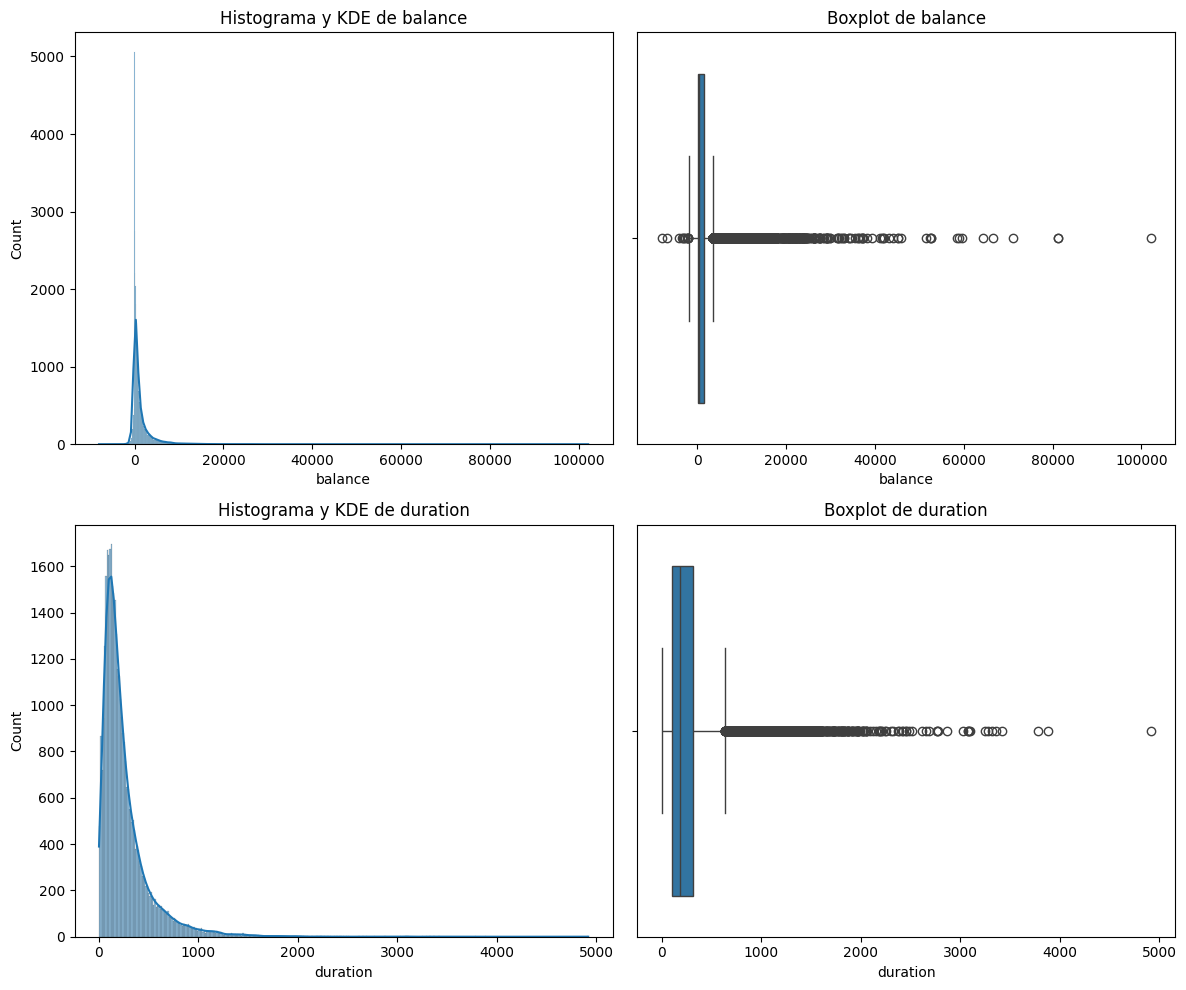

In [33]:
viz.plot_combined_graphs(train_set_transformado, columns=features_num)

Comentarios sobre las *features*:
1. balance: presenta una distribución con *heavy-tail* que debemos de tratar. También escalaremos el rango de valores
2. duration: presenta una distribución con *heavy-tail* que debemos de tratar. También escalaremos el rango de valores

Aplicamos la raíz cúbica (no aplicamos el logaritmo porque hay valores a 0) a los valores para tratar de centrarlos, tanto en train como en test 

In [34]:
for columna in features_num:
    train_set_transformado[columna] = train_set_transformado[columna].apply(np.cbrt)
    test_set_transformado[columna] = test_set_transformado[columna].apply(np.cbrt)


Visualizamos la distribución de las *features* numéricas de train tras aplicar la raiz cúbica

,count,mean,std,min,25%,50%,75%,max
balance,36168.0,7.440593,6.608527,-20.015821,4.121285,7.646027,11.263605,46.742671
duration,36168.0,5.844054,1.752602,0.000000,4.687548,5.646216,6.825624,17.005765


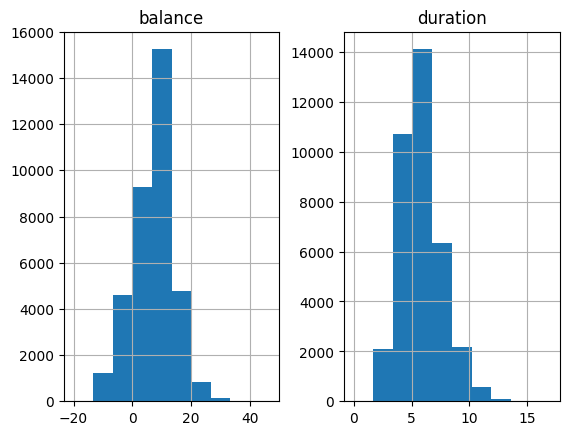

In [35]:
train_set_transformado[features_num].hist()
train_set_transformado[features_num].describe().T

Mejora la distribución ya que aparece mas centrada. Ahora estandarizamos las variables numéricas de los DataFrames de train y test

In [36]:
scaler = StandardScaler()

scaler.fit(train_set_transformado[features_num]) #Hacemos el fit solo con los datos de train

train_set_transformado[features_num] = scaler.transform(train_set_transformado[features_num])
test_set_transformado[features_num] = scaler.transform(test_set_transformado[features_num])

Visualizamos la distribución de las *features* numéricas tras aplicar el escalado

,count,mean,std,min,25%,50%,75%,max
balance,36168.0,3.143299e-18,1.000014,-4.154752,-0.502283,0.031087,0.578505,5.947259
duration,36168.0,-2.514639e-17,1.000014,-3.334548,-0.659889,-0.112884,0.560072,6.368740


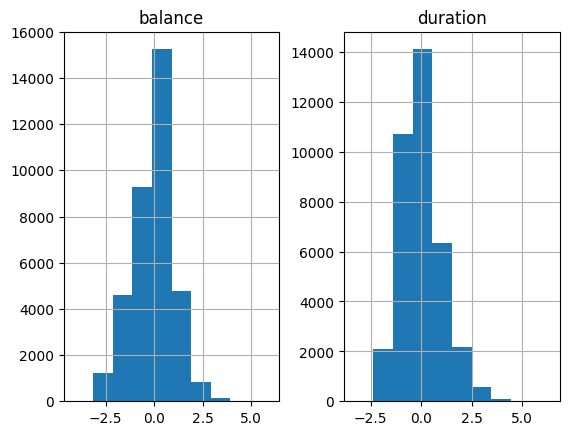

In [38]:
train_set_transformado[features_num].hist()
train_set_transformado[features_num].describe().T

# 5. Modelo de árboles de decisión

In [39]:
X_train = train_set_transformado.drop(columns=target)
y_train = train_set_transformado[target]

X_test = test_set_transformado.drop(columns=target)
y_test = test_set_transformado[target]

Creamos el modelo de árboles de decisión y lo entrenamos

In [40]:
tree_clf = DecisionTreeClassifier(max_depth=2, class_weight="balanced", random_state=42) #Usamos el hiperparámetro class_weight con la opción "balanced" ya que el target esta muy desbalanceado

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42)

## 5.1. Evaluación de errores para train y test

Evaluamos los errores de train

In [41]:
#Predicciones de train
pred_train = tree_clf.predict(X_train)

#Generamos el classification report 
report = classification_report(y_train, pred_train)
print(report)

              precision    recall  f1-score   support

          no       0.97      0.61      0.75     31970
         yes       0.23      0.87      0.36      4198

    accuracy                           0.64     36168
   macro avg       0.60      0.74      0.55     36168
weighted avg       0.89      0.64      0.70     36168



Evaluamos los errores de test

In [42]:
#Predicciones de test
pred_test = tree_clf.predict(X_test)

#Generamos el classification report 
report = classification_report(y_test, pred_test)
print(report)

              precision    recall  f1-score   support

          no       0.97      0.60      0.74      7952
         yes       0.23      0.87      0.36      1091

    accuracy                           0.63      9043
   macro avg       0.60      0.73      0.55      9043
weighted avg       0.88      0.63      0.70      9043



Tenemos que para este modelo entrenado sin optimizar sus hiperparámetros hay una buena generalización ya que se obtienen métricas muy similares en train y test. También tenemos que el *accuracy* en train y test es un 64% y 63% respectivamente

Sí que es cierto que se ha usado el hiperparámetro *class_weight='balanced'* al entrenar el modelo porque el dataset esta muy desbalanceado (el valor "no" del *target* suponía el 88% de los datos) y de no haberlo usado las métricas de *accuracy* cuando evaluamos train y test que se obtendrían son 89% y 90% respectivamente, es decir, que el modelo no ha "aprendido" nada, solo se ha ajustado a la situación mas probable al estar tan desbalanceado

# 6. Optimización del modelo de árboles de decisión con hiperparámetros

## 6.1. Método *Random Search*

Vamos ahora a buscar optimizar el modelo mediante una selección de hiperparámetros. Empezamos usando el método *Random Search*

In [43]:
#Creamos el grid de hiperparámetros
tree_param_grid = {
    'max_depth': [None] + list(range(1, 21)),
    'min_samples_split': [2,4,8,10],
    'min_samples_leaf': [2,4,8,10]
}

print(tree_param_grid)

{'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_samples_split': [2, 4, 8, 10], 'min_samples_leaf': [2, 4, 8, 10]}


In [44]:
#RandomizedSearch para DecisionTreeClassifier
tree_random_search = RandomizedSearchCV(tree_clf, tree_param_grid, n_iter=100, cv=10, scoring='accuracy', random_state=42, n_jobs=-1)
tree_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=2,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20],
                                        'min_samples_leaf': [2, 4, 8, 10],
                                        'min_samples_split': [2, 4, 8, 10]},
                   random_state=42, scoring='accuracy')

Miramos los mejores hiperparámetros encontrados con el método *Random Search*

In [45]:
tree_random_search.best_params_

{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None}

Miramos la métrica del modelo con los mejores hiperparámetros obtenidos con el método *Random Search*

In [46]:
#Obtenemos la métrica accuracy del modelo de árbol de decisión con los mejores hiperparámetros encontrados
tree_random_search.best_score_

0.8333886379706449

Hemos consegido optimizar con éste método el *accuracy* del modelo, pasando de un 64% a un 83% en train. Si evaluamos con el test:

In [47]:
#Predicciones del modelo optimizado con Random Search
y_pred = tree_random_search.best_estimator_.predict(X_test)

#Mostramos el classification report 
report_RS = classification_report(y_test, y_pred)
print(report_RS)

              precision    recall  f1-score   support

          no       0.94      0.86      0.90      7952
         yes       0.38      0.63      0.47      1091

    accuracy                           0.83      9043
   macro avg       0.66      0.74      0.69      9043
weighted avg       0.88      0.83      0.85      9043



Vemos que el *accuracy* sigue siendo bueno, de un 83%

## 6.2. Método *Grid Search*

Vamos a afinar aún más aplicando el método *Grid Search*

In [48]:
#GridSearch para DecisionTreeClassifier
tree_grid_search = GridSearchCV(tree_clf, tree_param_grid, cv=10, scoring='accuracy', n_jobs=-1)
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=2, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                       12, 13, 14, 15, 16, 17, 18, 19, 20],
                         'min_samples_leaf': [2, 4, 8, 10],
                         'min_samples_split': [2, 4, 8, 10]},
             scoring='accuracy')

Miramos los mejores hiperparámetros encontrados con el método *Grid Search*

In [49]:
tree_grid_search.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

Miramos la métrica del modelo con los mejores hiperparámetros obtenidos con el método *Grid Search*

In [50]:
tree_grid_search.best_score_

0.8540143903176005

Obtenemos incluso un mejor *accuracy* de un 85% en train. Si evaluamos con el test:

In [51]:
#Predicciones del modelo optimizado con Grid Search
y_pred = tree_grid_search.best_estimator_.predict(X_test)

#Mostramos el classification report 
report_GS = classification_report(y_test, y_pred)
print(report_GS)

              precision    recall  f1-score   support

          no       0.93      0.89      0.91      7952
         yes       0.39      0.51      0.44      1091

    accuracy                           0.84      9043
   macro avg       0.66      0.70      0.67      9043
weighted avg       0.86      0.84      0.85      9043



Vemos que el *accuracy* sigue siendo bueno, un 84%, mejor que el obtenido con el método *Random Search*

Mostramos todos los *classification report* obtenidos con test

In [52]:
print("Modelo sin optimizar:")
print(report)
print("Modelo optimizado con Random Search:")
print(report_RS)
print("Modelo optimizado con Grid Search:")
print(report_GS)

Modelo sin optimizar:
              precision    recall  f1-score   support

          no       0.97      0.60      0.74      7952
         yes       0.23      0.87      0.36      1091

    accuracy                           0.63      9043
   macro avg       0.60      0.73      0.55      9043
weighted avg       0.88      0.63      0.70      9043

Modelo optimizado con Random Search:
              precision    recall  f1-score   support

          no       0.94      0.86      0.90      7952
         yes       0.38      0.63      0.47      1091

    accuracy                           0.83      9043
   macro avg       0.66      0.74      0.69      9043
weighted avg       0.88      0.83      0.85      9043

Modelo optimizado con Grid Search:
              precision    recall  f1-score   support

          no       0.93      0.89      0.91      7952
         yes       0.39      0.51      0.44      1091

    accuracy                           0.84      9043
   macro avg       0.66      0.70 

Hay una clara mejoría del modelo con el método *Grid Search*:
* *accuracy* aumenta de un 63% a un 84%
* *precision* disminuye muy poco para el valor "no", se mantiene en un buen 93%, y aumenta bastante para el valor "yes" de 23% a 39%
* *recall* aumenta significativamente para el valor "no" de un 60% a un 89%, aunque el único inconveniente es que disminuye para el valor "yes" de un 87% a un 51%

# 7. Comparativa del modelo de árboles de decisión (optimizado) Vs. modelo de regresión logística (sin optimizar)

Creamos el modelo de regresión logística con sus hiperparámetros por defecto y lo entrenamos

In [53]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Nos está avisando para que aumentemos el número de iteraciones porque cree no haber encontrado la convergencia en la creación del modelo. Evaluamos los errores para test

In [54]:
#Predicciones del modelo de regresion logística
y_pred = log_reg.predict(X_test)

#Mostramos el classification report 
report_rl = classification_report(y_test, y_pred)
print("Modelo de regresión logística sin optimizar:")
print(report_rl)

Modelo de regresión logística sin optimizar:
              precision    recall  f1-score   support

          no       0.92      0.97      0.94      7952
         yes       0.63      0.34      0.45      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.69      9043
weighted avg       0.88      0.90      0.88      9043



In [55]:
print("Modelo de árboles de decisión optimizado con Grid Search:")
print(report_GS)

Modelo de árboles de decisión optimizado con Grid Search:
              precision    recall  f1-score   support

          no       0.93      0.89      0.91      7952
         yes       0.39      0.51      0.44      1091

    accuracy                           0.84      9043
   macro avg       0.66      0.70      0.67      9043
weighted avg       0.86      0.84      0.85      9043



Con el modelo de regresión logística se obtienen mejoras métricas de:
* *accuracy* que aumenta de un 84% a un 90%
* *precision* para el valor "yes", aumentando de un 39% a un 63%
* *recall* para el valor "no", aumentando de un 89% a un 97%

Sin embargo, empeoran las métricas de:
* *recall* para el valor "yes", disminuyendo de un 51% a un 34%

También hay que tener en cuenta que no se ha usado el hiperparámetro *class_weight="balanced"* en el modelo de regresión logística para tratar el gran desbalanceo del *target*. Un futuro paso que tomaría para terminar de elegir un modelo u otro sería evaluar las métricas del modelo de regresión logística pero creado con el hiperparámetro *class_weight="balanced"*